# Naive implementation for Corneal scar identification (Haze)

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tkinter as tk
from tkinter import filedialog
import scipy.ndimage as img
import scipy.signal as sgn
from Fonction_fit import fit_curve2D_seuil, fit_curve2D
from copy import deepcopy

In [2]:
# root = tk.Tk()
# filepathname = filedialog.askopenfilename(initialdir='\\', title='Sélectionnez l\'image OCT que vous souhaitez analyser :', parent=root)
# root.update()
# root.destroy()
filepathname="C:/Users/csoub/OneDrive/Bureau/3A/Ensta/Super projet/Algo_Maelle/Data/VILBERT_Maelle/test2.jpg"
print(filepathname)

C:/Users/csoub/OneDrive/Bureau/3A/Ensta/Super projet/Algo_Maelle/Data/VILBERT_Maelle/test2.jpg


In [3]:
def getImage(filepathname,champ_acquisition_mm=8):
    dict = {}
    dict.setdefault('z0', 10)
    z0 = dict['z0']                             # [px] coordonnée axiale du démarrage de la détection (10)
    # champ_acquisition_mm=8 #9:pachywide, 6:pachy, 8:full
    filename = filepathname #glob.glob(pathname + '\\*' + extension)[-1]
    X = mpimg.imread(filename)
    OCT_brut = X[z0:, 2:, 0]*1.0             # conversion en float64 en multipliant par 1.0 ([z0:, 2:, 0]*1.0)
    Path_eye="PachyWide"

    if Path_eye == "PachyWide":  
        champ_acquisition_mm= 9 # full = 9mm pour PachyWide
        pas = 4.322                   # [µm] pas axial (!), cf. calibration via pachymetry Optovue
    elif Path_eye == "Pachy":  
        champ_acquisition_mm=6 # full = 6mm pour Pachy
        pas = 4.333                   # [µm] pas axial
    else:
        champ_acquisition_mm=8 # full = 8mm
        pas = 4.333                   # [µm] pas axial 
    return(OCT_brut,Path_eye)

OCT_brut,Path_eye=getImage(filepathname)

## Function
$D/D$

In [4]:
def RomoveArrow(OCT_brut,sz_arrow = 70):
    OCT=OCT_brut
    OCT[0:sz_arrow,np.shape(OCT_brut)[1]-sz_arrow:np.shape(OCT_brut)[1]] = np.zeros((sz_arrow,sz_arrow)) 
    return(OCT)

def ExposureCorrection(OCT_brut):
	OCT_optim=OCT_brut
	hist_moy = np.mean(OCT_brut.ravel())
	if hist_moy > 25:
		hist_adjust = np.round(hist_moy - 18)
		OCT_optim = OCT_brut - hist_adjust
		OCT_optim[OCT_optim < 0] = 0
	return(OCT_optim)

def ImageSNR(mImage,gauss_sigma=1):
	signal = np.sum(np.square(mImage))
	noise = np.sum(np.square(mImage-img.gaussian_filter(mImage,sigma=gauss_sigma)))
	SNR = np.around(10*np.log10(signal/noise),1)
	return(SNR)

def Derivative1(Image,gauss_sigma=1):
        OCT = img.gaussian_filter(Image,sigma=gauss_sigma)
        mean_signal = np.mean(OCT, axis = 0)	
        mean_signal_smooth = sgn.savgol_filter(mean_signal,15,2)     # SG évite les discontinuités apparentes du filtre médian (qui feraient bugguer der1)
        der1 = np.diff(mean_signal_smooth)
        der1_smooth = sgn.savgol_filter(der1,15,2)
        return(mean_signal,mean_signal_smooth,der1,der1_smooth)

def HyperRefelxionRemoval(OCT_brut,champ_acquisition_mm,gauss_sigma=1,der1_seuil=0.67,marge=55):
        pas_lat = round(1000*champ_acquisition_mm/OCT_brut.shape[1],2)  # pas latéral
        marge = int(np.round(marge/pas_lat))
        
        mean_signal,mean_signal_smooth,der1,der1_smooth = Derivative1(OCT_brut,gauss_sigma)

        fig = plt.figure(2)
        plt.imshow(OCT_brut,cmap = 'gray')
        offset_aff = np.ceil(np.amax(mean_signal)) + 5
        #coeff = 20/(np.amax(der1)-np.amin(der1))
        lineN, = plt.plot(offset_aff + -mean_signal_smooth, color='tab:purple')
        lineO, = plt.plot(offset_aff + -10*der1, color='tab:green')
        columns_raw = OCT_brut.shape[1]
        coord_centre = np.where(mean_signal_smooth == np.amax(mean_signal_smooth[int(0.2*columns_raw):columns_raw-int(0.2*columns_raw)]))[0][0]

        if np.any(abs(der1[20:len(der1)-20]) > der1_seuil) :    # en évitant les bords            
                xmin_cut = np.where(der1_smooth == np.sort(der1_smooth[20:-20])[-1])[0][0] # (tuple to int)
                xmax_cut = np.where(der1_smooth == np.sort(der1_smooth[20:-20])[0])[0][0]
                xmin_cut = xmin_cut - marge
                xmax_cut = xmax_cut + marge    
                plt.axvline(xmin_cut, ymin=0, ymax=OCT_brut.shape[0]-1, color='tab:green', linestyle='dashed', linewidth=1)
                plt.axvline(xmax_cut, ymin=0, ymax=OCT_brut.shape[0]-1, color='tab:green', linestyle='dashed', linewidth=1)
                lineP, = plt.plot(np.ones([len(OCT_brut),1]), color='tab:green', linestyle = 'dashed', linewidth=1)
                SpecularCut = (xmax_cut-xmin_cut)*pas_lat
                plt.title("Coupure spéculaire auto : largeur = %i µm" %SpecularCut)
                plt.legend((lineN, lineO, lineP),('Signal latéral moyen lissé',
                        'Dérivée du signal latéral moyen lissé', 'Délimitation de l\'artefact spéculaire'), fontsize=11, loc = 'lower right')   
                lineP.set_visible(False) 
        else:    # pas de pic central détecté
                xmin_cut = 0
                xmax_cut = 0
                SpecularCut = 0              
        #        lineP, = plt.plot(np.ones([len(OCT),1]), color='tab:green', linestyle = 'dashed', linewidth=1.5)
        #        plt.axvline(coord_centre, ymin=0, ymax=OCT.shape[1]-1, color='tab:green', linestyle = 'dashed', linewidth = 1.5)
                plt.title('Détection auto de l\'artefact central : largeur = 0 µm')
        #        plt.legend((lineN, lineO, lineP),('Signal latéral moyen lissé', 'Dérivée du signal latéral moyen lissé', 'Centre de la cornée imagée : x = %i' %coord_centre), fontsize=11, loc = 'lower right') 
                plt.legend((lineN, lineO),('Signal latéral moyen lissé', 'Dérivée du signal latéral moyen lissé'), fontsize=11, loc = 'lower right') 
        #        lineP.set_visible(False)
        plt.show()
        OCT_cut_brut = np.delete(OCT_brut, range(xmin_cut, xmax_cut), axis=1)
        depth, columns = np.shape(OCT_cut_brut)
        return(OCT_cut_brut,xmin_cut,xmax_cut,depth,columns)

def flattening(OCT_image_cut,OCT_image,Path_eye,xmin_cut,xmax_cut,depth,columns,max_window_size=10,w_filter=101,median_filter_width=15,sgolay_order=2,w_filterNorm=115):
    SNR_2D=ImageSNR(OCT_image)
    seuil = int(-2*SNR_2D + 65) # (+ 65)            # [] seuil pour détection de l'épithélium (40)
    mean_signal,mean_signal_smooth,der1,der1_smooth = Derivative1(OCT_image)
    # if Path_eye == "PachyWide":
    #     seuil  = seuil - 10  #(-10)    
    # elif np.any(der1_smooth[50:xmin_cut] > 0.25) or np.any(der1_smooth[xmax_cut:-50] > 0.25):
    #     if SNR_2D < 16:
    #         seuil  = seuil #- 5#(-5)    # OK le 08/02/21 sur Faustine2
    #     else:                
    #         seuil = seuil + 10 #(+ 15)
    # else:
    #     seuil = seuil + 15 #(+ 15)
    if np.any(OCT_image_cut[0:50,] > 1.5*seuil):
        if SNR_2D < 15.5:
            seuil  = seuil + 15                    
    else:
        seuil = seuil + 25
    # seuil=41
    print('Epithelium detection threshold = %i'%seuil)

    OCT_cut = img.gaussian_filter(OCT_image_cut, sigma=2)

    fig = plt.figure(3)
    plt.imshow(OCT_cut, cmap = 'gray')
    plt.title('Détection de l\'épithélium')

    Displacement = abs(fit_curve2D_seuil(OCT_cut, seuil, w_filter, median_filter_width, sgolay_order))
    # Correction de la coordonnée centrale de la cornée
    coord_centre2 = int(np.where(Displacement == np.amin(Displacement[100:columns-100]))[0][0])
    offset = int(round(min(Displacement)))  # décalage pour visualiser l'épithélium sur les images aplaties
    Displacement = Displacement - min(Displacement)
        # Application du décalage
    FlattenedImage = np.zeros((depth, columns))
    for j in range(columns):
        if int(round(Displacement[j])) > 0:
            FlattenedImage[:-int(round(Displacement[j])), j] = OCT_image_cut[int(round(Displacement[j])):, j]
        else:
            FlattenedImage[:, j] = OCT_image_cut[:, j]
        # Raffinement de l'aplatissement
    max_window = [0, max_window_size + offset]
    Displacement = abs(fit_curve2D(FlattenedImage, max_window, w_filter, median_filter_width, sgolay_order))   
    plt.legend(('Détection des maxima locaux', 'Signal de l\'épithélium lissé', 'Offset brut', 'Offset lissé'), fontsize=11, loc = 'lower right')
    Displacement = Displacement - min(Displacement)
    FlattenedImage2 = np.zeros((depth, columns))
    for j in range(columns):
        if int(round(Displacement[j])) > 0:
            FlattenedImage2[:-int(round(Displacement[j])), j] = FlattenedImage[int(round(Displacement[j])):, j]
        else:
            FlattenedImage2[:, j] = FlattenedImage[:, j]
    plt.show()
    sgolay_orderNorm = sgolay_order             # ordre du filtre de SG    
    M = FlattenedImage2[:max_window[1], :]
    plt.figure()
    plt.imshow(FlattenedImage2,cmap='gray')
    plt.show()
    VectMax = M.max(axis=0)
#	VectNorm = sgn.medfilt(VectMax, filter_orderNorm)    # ==========================================================> encore très bruité !
    VectNorm = sgn.savgol_filter(VectMax, w_filterNorm, sgolay_orderNorm)
    VectNorm[VectNorm<=75] = 75
    ProcessedImage = deepcopy(FlattenedImage2/VectNorm)
    return(ProcessedImage)
    

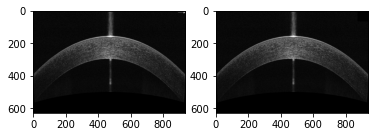

SNR init:  16.8
SNR after exposure correction:  16.8


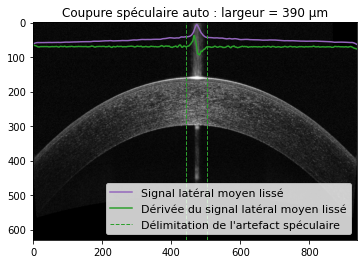

SNR after cut:  16.2


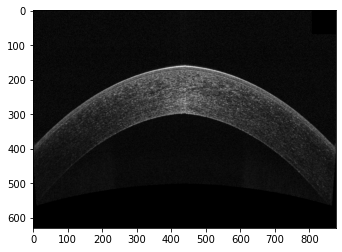

Epithelium detection threshold = 56


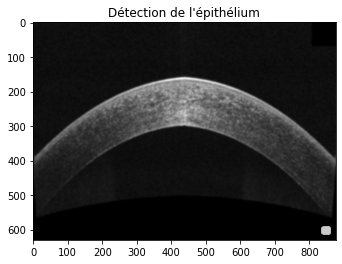

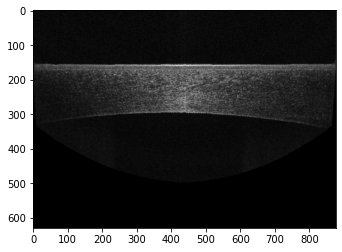

In [5]:
plt.subplot(121)
plt.imshow(OCT_brut,cmap='gray')
OCT=RomoveArrow(OCT_brut)
plt.subplot(122)
plt.imshow(OCT,cmap='gray')
plt.show()
print("SNR init: ",ImageSNR(OCT))

OCT=ExposureCorrection(OCT)
print("SNR after exposure correction: ",ImageSNR(OCT))
OCT_cut,xmin_cut,xmax_cut,depth,columns=HyperRefelxionRemoval(OCT,champ_acquisition_mm=6,marge=155)
plt.imshow(OCT_cut,cmap='gray')
print("SNR after cut: ",ImageSNR(OCT_cut))
plt.show()
FlattenedImage=flattening(OCT_cut,OCT,Path_eye,xmin_cut,xmax_cut,depth,columns)
plt.show()


In [6]:
def AutoTreatment(filepathname,champ_acquisition_mm=8,plot=False):
	if not plot:
		plt.ioff()
	else:
		plt.ion()
	OCT_brut,Path_eye=getImage(filepathname,champ_acquisition_mm)
	OCT=RomoveArrow(OCT_brut)
	OCT=ExposureCorrection(OCT)
	OCT_cut,xmin_cut,xmax_cut,depth,columns=HyperRefelxionRemoval(OCT,champ_acquisition_mm,marge=155)
	FlattenedImage=flattening(OCT_cut,OCT,Path_eye,xmin_cut,xmax_cut,depth,columns)
	plt.ion()
	return(FlattenedImage)

# Intensity profile analyse

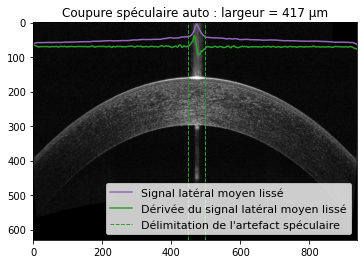

Epithelium detection threshold = 56


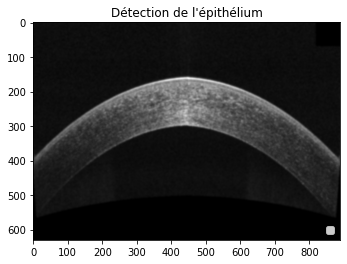

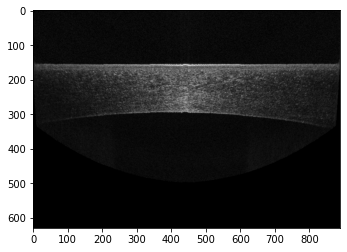

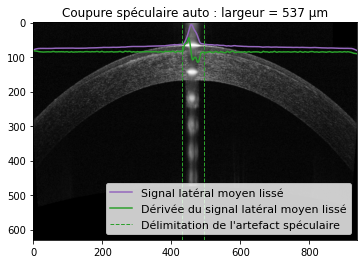

Epithelium detection threshold = 52


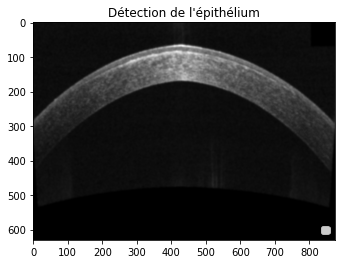

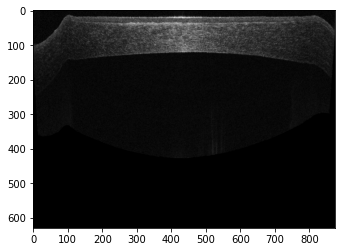

In [7]:
# %%capture
path1="C:/Users/csoub/OneDrive/Bureau/3A/Ensta/Super projet/Algo_Maelle/Data/VILBERT_Maelle/test2.jpg"
Image1=AutoTreatment(path1)
path2="C:/Users/csoub/OneDrive/Bureau/3A/Ensta/Super projet/Algo_Maelle/Data/HAZE/haze 3.jpg"
Image2=AutoTreatment(path2)


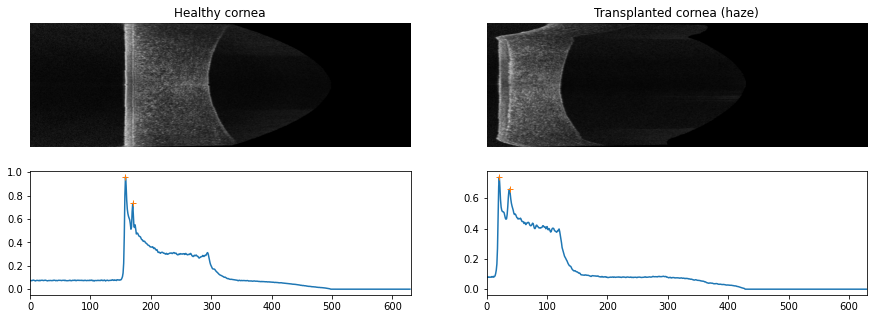

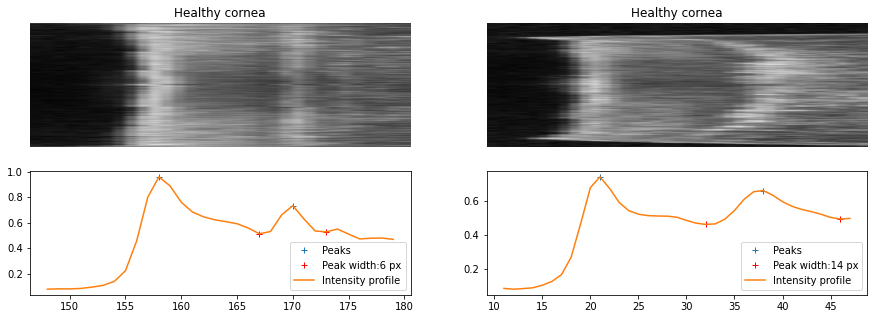

In [8]:
%matplotlib inline
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

# for local maxima
displayedPeak=2
window=10
def getPeaks(intentityProfile,displayedPeak=2):
	indexMax=np.argmax(intentityProfile)
	peak=argrelextrema(intentityProfile, np.greater)
	npeak1=np.unique(np.where(peak >= indexMax, peak,indexMax)[0])
	return(npeak1[0:displayedPeak])

def getLowPeak(peak,cropedProfile,xmin):
	peakLow=argrelextrema(cropedProfile, np.less)+xmin
	low1=np.unique(np.where(peakLow < peak[1], peakLow,peak[1])[0])#[:-1]
	if(low1.shape[0]>1):
			xlow1=low1[-1]
			if xlow1==peak[1]:
				xlow1=low1[-2]
	else:
		xlow1=low1[0]
	
	low2=np.unique(np.where(peakLow >= peak[1], peakLow,peak[1])[0])#[1:]
	if(low2.shape[0]>1):
		xlow2=low2[0]
		if xlow2==peak[1]:
			xlow2=low2[1]
	elif (low2.shape[0]==1):
		xlow2=low2[0]
		if xlow2==peak[1]:
			xlow2=cropedProfile.shape[0]+xmin-1
	else:
		xlow2=cropedProfile.shape[0]+xmin-1
	return(xlow1,xlow2)

plt.figure(figsize=(15,5))
intentityProfile1=np.mean(Image1,1)
plt.subplot(221)
plt.imshow(Image1.transpose(),cmap="gray",aspect="auto")
plt.title("Healthy cornea")
plt.axis("off")
plt.subplot(223)
plt.plot(intentityProfile1)
plt.xlim([0,intentityProfile1.shape[0]])
peak1=getPeaks(intentityProfile1,displayedPeak)
plt.plot(peak1,intentityProfile1[peak1],'+')

intentityProfile2=np.mean(Image2,1)
plt.subplot(222)
plt.imshow(Image2.transpose(),cmap="gray",aspect="auto")
plt.title("Transplanted cornea (haze)")
plt.axis("off")
plt.subplot(224)
plt.plot(intentityProfile2)
plt.xlim([0,intentityProfile2.shape[0]])
peak2=getPeaks(intentityProfile2,displayedPeak)
plt.plot(peak2,intentityProfile2[peak2],'+')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(221)
xmin=peak1[0]-window;xmax=peak1[-1]+window
plt.imshow(Image1.transpose()[:,xmin:xmax],cmap="gray",aspect="auto")
plt.title("Healthy cornea")
plt.axis("off")
plt.subplot(223)
cropedProfile=intentityProfile1[xmin:xmax]
plt.plot(peak1,intentityProfile1[peak1],'+')

xlow1,xlow2=getLowPeak(peak1,cropedProfile,xmin)
plt.plot([xlow1,xlow2],[intentityProfile1[xlow1],intentityProfile1[xlow2]],"r+")
plt.plot(np.arange(xmin,xmax),cropedProfile)
extractedProf1=intentityProfile1[xlow1:xlow2+1]
plt.legend(["Peaks","Peak width:"+str(xlow2-xlow1)+" px","Intensity profile"])

plt.subplot(222)
xmin=peak2[0]-window;xmax=peak2[-1]+window
plt.imshow(Image2.transpose()[:,xmin:xmax],cmap="gray",aspect="auto")
plt.title("Healthy cornea")
plt.axis("off")
plt.subplot(224)
cropedProfile=intentityProfile2[xmin:xmax]
plt.plot(peak2,intentityProfile2[peak2],'+')

xlow1,xlow2=getLowPeak(peak2,cropedProfile,xmin)
# print(xlow1,xlow2)
plt.plot([xlow1,xlow2],[intentityProfile2[xlow1],intentityProfile2[xlow2]],"r+")
plt.plot(np.arange(xmin,xmax),cropedProfile)
extractedProf2=intentityProfile2[xlow1:xlow2+1]
plt.legend(["Peaks","Peak width:"+str(xlow2-xlow1)+" px","Intensity profile"])

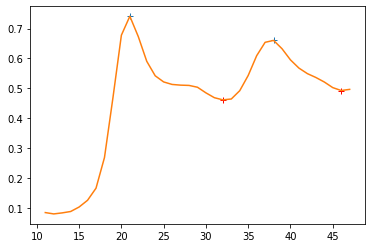

In [15]:
plt.plot(peak1,intentityProfile2[peak1],'+')
plt.plot([xlow1,xlow2],[intentityProfile2[xlow1],intentityProfile2[xlow2]],"r+")
plt.plot(np.arange(xmin,xmax),cropedProfile)



mean: 6
cov [[0.00398282 0.00363989]
 [0.00363989 0.00378035]]
param [0.18623157 6.45356563 2.86794054]


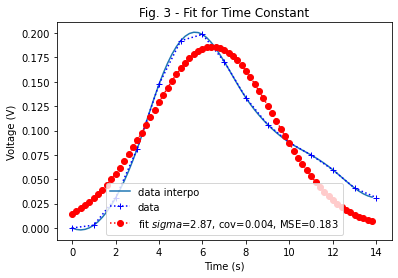

In [9]:
from scipy import interpolate

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


data=extractedProf2
y=data-np.min(data)
# y=gaus(np.arange(0,10),1,4,1)
n=y.shape[0]
x=np.arange(0,n)
mean=np.argmax(y)
print("mean:",mean)
sigma=0.1
tck = interpolate.splrep(x, y, s=0)
xnew = np.arange(0, n-1, 1/5)
ynew = interpolate.splev(xnew, tck, der=0)
plt.plot(xnew,ynew,label='data interpo')

popt,pcov = curve_fit(gaus,xnew,ynew,p0=[1,mean,sigma])
data_cov=np.cov(ynew,gaus(xnew,*popt))
MSE=np.sqrt(np.sum((ynew-gaus(xnew,*popt))**2))
print("cov",data_cov)
print("param",popt)
plt.plot(x,y,'b+:',label='data')
plt.plot(xnew,gaus(xnew,*popt),'ro:',label='fit $sigma$={:.2f}, cov={:.3f}, MSE={:.3f}'.format(popt[2],data_cov[0,1],MSE))
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()


mean: 6
cov [[0.00398282 0.00355511]
 [0.00355511 0.00326321]]
param [2.53890884e+05 3.12682948e+01]


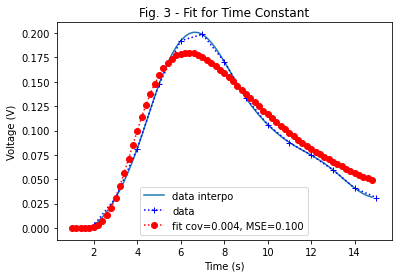

In [10]:
def plank(x,a,b):
	return(a/x**5*1/(np.exp(b/x)-1))

y=data-np.min(data)
# y=gaus(np.arange(0,10),1,4,1)
n=y.shape[0]
x=np.arange(1,n+1)
mean=np.argmax(y)
print("mean:",mean)
sigma=0.1
tck = interpolate.splrep(x, y, s=0)
xnew = np.arange(1, n, 1/5)
ynew = interpolate.splev(xnew, tck, der=0)
plt.plot(xnew,ynew,label='data interpo')

popt,pcov = curve_fit(plank,xnew,ynew,p0=[1,1])

data_cov=np.cov(ynew,plank(xnew,*popt))
MSE=np.sqrt(np.sum((ynew-plank(xnew,*popt))**2))
print("cov",data_cov)
print("param",popt)
plt.plot(x,y,'b+:',label='data')
plt.plot(xnew,plank(xnew,*popt),'ro:',label='fit cov={:.3f}, MSE={:.3f}'.format(data_cov[0,1],MSE))
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()